Episode 50: Total Reward = 145
Episode 100: Total Reward = 159
Episode 150: Total Reward = 149
Episode 200: Total Reward = 152
Episode 250: Total Reward = 124
Episode 300: Total Reward = 136
Episode 350: Total Reward = 151
Episode 400: Total Reward = 157
Episode 450: Total Reward = 135
Episode 500: Total Reward = 149


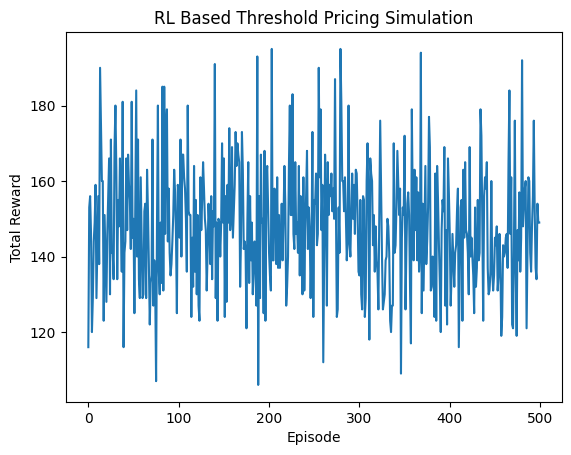

In [1]:
import numpy as np
import gym
from gym import spaces
import random
import matplotlib.pyplot as plt

class ThresholdPricingEnv(gym.Env):
    """
    A simple simulation environment for threshold pricing.
    The agent chooses a threshold price (action) and receives a reward based on a simulated customer's willingness to pay.
    """
    def __init__(self):
        super(ThresholdPricingEnv, self).__init__()
        # Define action space: discrete actions 0-9 correspond to threshold prices 1 to 10.
        self.action_space = spaces.Discrete(10)
        # Define observation space: a single integer representing market demand (or a similar state variable).
        self.observation_space = spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32)
        self.state = None

    def reset(self):
        # Initialize the state; for example, a random demand between 10 and 50.
        self.state = np.array([np.random.randint(10, 50)], dtype=np.float32)
        return self.state

    def step(self, action):
        """
        Executes one time step within the environment.
        :param action: integer from 0 to 9 corresponding to a threshold price (action+1)
        :return: tuple (next_state, reward, done, info)
        """
        # Map action to threshold price (e.g., action=0 -> price=1, action=9 -> price=10)
        threshold_price = action + 1
        # Simulate customer's willingness to pay (WTP) uniformly between 1 and 10.
        customer_wtp = np.random.uniform(1, 10)
        # If threshold is acceptable to the customer, reward is the threshold price; else, no reward.
        reward = threshold_price if threshold_price <= customer_wtp else 0
        # Transition: update state (here we simply generate a new random demand)
        self.state = np.array([np.random.randint(10, 50)], dtype=np.float32)
        # In this simulation, the episode can be continuous. You can add a condition to end an episode if needed.
        done = False
        return self.state, reward, done, {}

if __name__ == "__main__":
    # Create the environment
    env = ThresholdPricingEnv()
    num_actions = env.action_space.n

    # Initialize Q-table; assuming state is an integer in [0, 100].
    Q_table = np.zeros((101, num_actions))

    # Q-learning hyperparameters
    alpha = 0.1        # Learning rate
    gamma = 0.95       # Discount factor
    epsilon = 0.1      # Exploration rate
    episodes = 500     # Total number of episodes
    steps_per_episode = 100

    rewards_all = []

    # Q-learning training loop
    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        for step in range(steps_per_episode):
            # Discretize the state (demand) for indexing in Q-table
            state_idx = int(state[0])
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[state_idx])
            # Take action and observe reward and next state
            next_state, reward, done, _ = env.step(action)
            next_state_idx = int(next_state[0])
            # Q-learning update rule
            best_next_action = np.argmax(Q_table[next_state_idx])
            td_target = reward + gamma * Q_table[next_state_idx, best_next_action]
            td_error = td_target - Q_table[state_idx, action]
            Q_table[state_idx, action] += alpha * td_error

            state = next_state
            total_reward += reward
            if done:
                break
        rewards_all.append(total_reward)
        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}: Total Reward = {total_reward}")

    # Plot total reward per episode to visualize learning progress
    plt.plot(rewards_all)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("RL Based Threshold Pricing Simulation")
    plt.show()


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
<ipython-input-2-a403b5602c2a>:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  agent_price = float(np.clip(action, 0, 20))


Episode 50/500: Total Reward = 81.47
Episode 100/500: Total Reward = 299.12
Episode 150/500: Total Reward = 447.02
Episode 200/500: Total Reward = 373.14
Episode 250/500: Total Reward = 405.70
Episode 300/500: Total Reward = 371.44
Episode 350/500: Total Reward = 298.45
Episode 400/500: Total Reward = 376.71
Episode 450/500: Total Reward = 355.21
Episode 500/500: Total Reward = 259.35


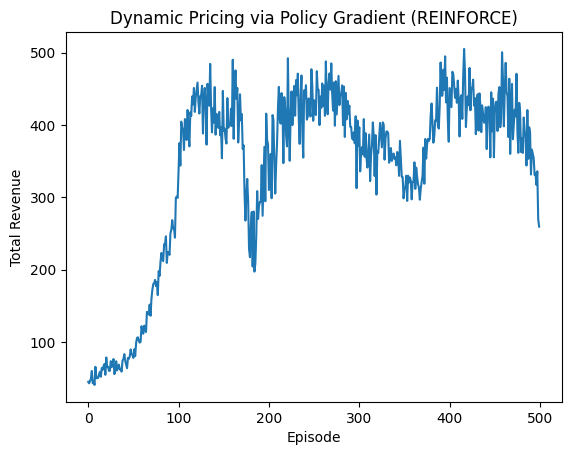

In [2]:
import numpy as np
import math
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt
import unittest

# ===============================
# Environment: DynamicPricingEnv
# ===============================
class DynamicPricingEnv(gym.Env):
    """
    A custom environment for dynamic pricing with:
      - Seasonality effects on customer willingness-to-pay (WTP).
      - A competitor setting a dynamic price.

    State: a 3-dimensional vector consisting of:
      [normalized_time, seasonal_factor, competitor_price]

    Action: a continuous price in the range [0, 20].

    Reward: if the agent's price is below the customer's WTP,
              the chance of making a sale depends on how it compares with competitor pricing.
            - If agent's price < competitor's price (by a margin), sale probability = 0.8.
            - If prices are almost equal, probability = 0.5.
            - If agent's price > competitor's price, probability = 0.2.
            - If agent's price > customer WTP, no sale occurs.
            The reward is the agent's price (revenue) if a sale occurs, 0 otherwise.
    """
    def __init__(self):
        super(DynamicPricingEnv, self).__init__()
        # Episode parameters
        self.max_steps = 100
        self.current_step = 0
        self.period = 50  # period for seasonality

        # Customer WTP parameters
        self.base_wtp = 10.0
        self.wtp_std = 2.0  # standard deviation

        # Competitor pricing parameters
        self.competitor_base = 8.0
        self.competitor_amplitude = 1.5
        self.competitor_phase = math.pi / 4
        self.competitor_noise_std = 0.5

        # Define observation space: [normalized_time, seasonal_factor, competitor_price]
        low_obs = np.array([0.0, -1.0, 0.0], dtype=np.float32)
        high_obs = np.array([1.0, 1.0, 20.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        # Action space: continuous price between 0 and 20.
        self.action_space = spaces.Box(low=np.array([0.0]), high=np.array([20.0]), dtype=np.float32)

    def _get_seasonality(self, step):
        return math.sin(2 * math.pi * step / self.period)

    def _get_competitor_price(self, step):
        base = self.competitor_base
        amplitude = self.competitor_amplitude
        phase = self.competitor_phase
        seasonal = math.sin(2 * math.pi * step / self.period + phase)
        noise = np.random.normal(0, self.competitor_noise_std)
        return np.clip(base + amplitude * seasonal + noise, 0, 20)

    def reset(self):
        self.current_step = 0
        normalized_time = self.current_step / self.max_steps
        seasonal_factor = self._get_seasonality(self.current_step)
        competitor_price = self._get_competitor_price(self.current_step)
        state = np.array([normalized_time, seasonal_factor, competitor_price], dtype=np.float32)
        return state

    def step(self, action):
        # Ensure action is a scalar price
        agent_price = float(np.clip(action, 0, 20))
        self.current_step += 1
        normalized_time = self.current_step / self.max_steps
        seasonal_factor = self._get_seasonality(self.current_step)
        competitor_price = self._get_competitor_price(self.current_step)

        # Customer WTP: mean influenced by seasonality
        mean_wtp = self.base_wtp + seasonal_factor
        customer_wtp = np.random.normal(mean_wtp, self.wtp_std)
        customer_wtp = max(customer_wtp, 0)  # ensure nonnegative

        # Determine sale probability based on pricing and competitor pricing
        if agent_price > customer_wtp:
            sale_prob = 0.0
        else:
            if agent_price < competitor_price - 0.01:
                sale_prob = 0.8
            elif abs(agent_price - competitor_price) < 0.01:
                sale_prob = 0.5
            else:
                sale_prob = 0.2

        sale_occurred = np.random.rand() < sale_prob
        reward = agent_price if sale_occurred else 0.0

        done = self.current_step >= self.max_steps
        next_state = np.array([normalized_time, seasonal_factor, competitor_price], dtype=np.float32)
        return next_state, reward, done, {}

# ===============================
# Policy Network (Gaussian Policy)
# ===============================
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim=3, hidden_dim=64, action_dim=1):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Output the mean price
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        # Output the log standard deviation (for numerical stability)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        """
        Given a state, output a Normal distribution over prices.
        """
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mean = self.mean_head(x)
        std = torch.exp(self.log_std)
        return Normal(mean, std)

# ===============================
# REINFORCE Training Loop
# ===============================
def train(policy, env, optimizer, episodes=500, max_steps=100, gamma=0.99):
    episode_rewards = []
    for ep in range(episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        total_reward = 0

        for t in range(max_steps):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)  # shape [1, state_dim]
            dist = policy(state_tensor)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            # Convert action to numpy scalar
            action_np = action.detach().numpy()[0]

            next_state, reward, done, _ = env.step(action_np)
            log_probs.append(log_prob)
            rewards.append(reward)
            total_reward += reward

            state = next_state
            if done:
                break

        # Compute discounted returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)

        # Normalize returns (optional, but often helpful)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # Compute policy loss
        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)
        optimizer.zero_grad()
        loss = torch.cat(policy_loss).sum()
        loss.backward()
        optimizer.step()

        episode_rewards.append(total_reward)
        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}/{episodes}: Total Reward = {total_reward:.2f}")
    return episode_rewards

# ===============================
# Unit Tests for Environment and Policy
# ===============================
class TestDynamicPricingEnv(unittest.TestCase):
    def setUp(self):
        self.env = DynamicPricingEnv()

    def test_reset(self):
        state = self.env.reset()
        self.assertEqual(state.shape, (3,))
        self.assertTrue(0.0 <= state[0] <= 1.0)

    def test_step(self):
        state = self.env.reset()
        action = np.array([10.0], dtype=np.float32)
        next_state, reward, done, _ = self.env.step(action)
        self.assertEqual(next_state.shape, (3,))
        self.assertIsInstance(reward, float)
        self.assertIsInstance(done, bool)

    def test_policy_network(self):
        policy = PolicyNetwork()
        dummy_state = torch.FloatTensor([0.5, 0.0, 9.0]).unsqueeze(0)
        dist = policy(dummy_state)
        sample_action = dist.sample()
        self.assertEqual(sample_action.shape, (1,))

# ===============================
# Main: Run training and/or tests
# ===============================
if __name__ == "__main__":
    # To run tests, uncomment the following two lines:
    # unittest.main(exit=False)
    # exit(0)

    # Training parameters
    episodes = 500
    max_steps = 100
    gamma = 0.99
    learning_rate = 1e-3

    # Create environment and policy network
    env = DynamicPricingEnv()
    policy = PolicyNetwork()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    # Train the policy using REINFORCE
    rewards = train(policy, env, optimizer, episodes=episodes, max_steps=max_steps, gamma=gamma)

    # Plot learning progress
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Revenue")
    plt.title("Dynamic Pricing via Policy Gradient (REINFORCE)")
    plt.show()
